## IMPORTATION DES LIBRAIRIES 

In [1]:
### Importations de base
import numpy as np
import pandas as pd
import os
import gc
import time
import timeit
import datetime
import random
import statistics
import warnings
from contextlib import contextmanager

### Importations pour la visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import missingno as msno
from tqdm.notebook import tqdm
from IPython.display import display, HTML

### Importations pour la manipulation des données
import re
from scipy import stats

### Importations pour le Machine Learning
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, auc,  roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn import cluster, metrics
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

### Importations pour MLFLOW
import mlflow
import mlflow.sklearn

### Importations pour SHAP et gestion des avertissements spécifiques
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import shap
shap.initjs()
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

### Paramètres pandas
pd.set_option('mode.chained_assignment', None)  # Pour éviter la survenue de messages d'erreur lors de la création d'un nouveau dataframe à partir d'un existant
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.options.display.width = 50
pd.options.display.max_colwidth = 1000

### Optionnel : Filtrer les avertissements
from warnings import filterwarnings
filterwarnings('ignore')


In [2]:
# Parallélisation avec joblib
from joblib import Parallel, delayed

# Fonction pour élever un nombre au carré (utilisée pour illustrer la parallélisation avec joblib)
def process_data_joblib(i):
    return i * i

# Exécution avec joblib
print("Execution avec joblib")
results_joblib = Parallel(n_jobs=-1)(delayed(process_data_joblib)(i) for i in range(10000))
print("Terminé joblib")

# Parallélisation avec concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed

# Fonction pour élever un nombre au carré (utilisée pour illustrer la parallélisation avec concurrent.futures)
def process_data_futures(i):
    return i * i

print("Execution avec concurrent.futures")
with ThreadPoolExecutor(max_workers=4) as executor:  # Vous pouvez ajuster le nombre de workers
    futures = [executor.submit(process_data_futures, i) for i in range(10000)]
    results_futures = [f.result() for f in as_completed(futures)]
print("Terminé concurrent.futures")

# Parallélisation avec multiprocessing
from multiprocessing import Pool

"""
# Fonction pour élever un nombre au carré (utilisée pour illustrer la parallélisation avec multiprocessing)
def process_data_multiprocessing(i):
    return i * i

print("Execution avec multiprocessing")
with Pool(processes=4) as pool:  # Ajustez le nombre de processus en fonction de votre CPU
    results_multiprocessing = pool.map(process_data_multiprocessing, range(10000))
print("Terminé multiprocessing") """

# Accélération avec Numba
from numba import jit
import numpy as np

# Fonction optimisée par Numba pour calculer la somme des carrés d'un tableau de nombres
@jit(nopython=True, parallel=True)
def process_data_numba(arr):
    result = 0
    for i in arr:
        result += i ** 2
    return result

print("Execution avec Numba")
arr = np.arange(1000000)
results_numba = process_data_numba(arr)
print("Terminé Numba")

Execution avec joblib
Terminé joblib
Execution avec concurrent.futures
Terminé concurrent.futures
Execution avec Numba
Terminé Numba


## 1 - Apprentissage automatique ou machine learning

In [3]:
# Chargement des données depuis le fichier CSV "AnciensClients.csv"
Data = pd.read_csv(r'C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Data_clean/AnciensClients.csv')
Data.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,...,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRA

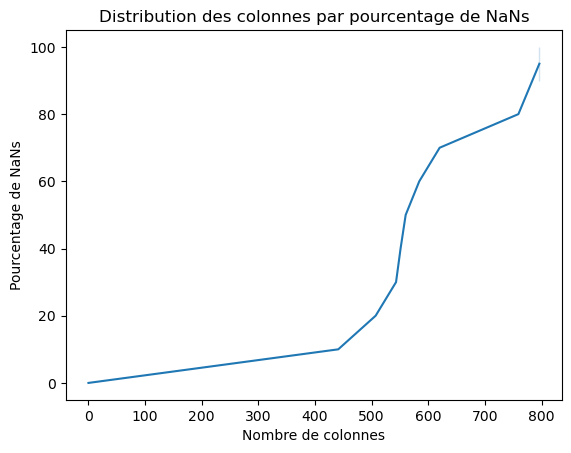

Il y a 176 variables avec plus de 70% de NaNs.
Il y a 212 variables avec plus de 60% de NaNs.
Il y a 236 variables avec plus de 50% de NaNs.
Il y a 245 variables avec plus de 40% de NaNs.
Il y a 253 variables avec plus de 30% de NaNs.

Fichier exporté vers C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Données générée\Application_projet7_Streamlit.csv


In [4]:
# Calcul du pourcentage de valeurs manquantes (NaNs) par colonne
pourcentage_nan_par_colonne = (Data.isna().mean() * 100).astype(int)

# Création d'un DataFrame avec les pourcentages de NaNs
dataframe_pourcentage_nan = pd.DataFrame(pourcentage_nan_par_colonne, columns=['Pourcentage_NaNs'])

# Calcul du nombre de colonnes ayant moins de NaNs qu'un certain pourcentage
nombre_colonnes_sans_nan = [
    Data.shape[1] - dataframe_pourcentage_nan[dataframe_pourcentage_nan['Pourcentage_NaNs'] >= seuil].shape[0]
    for seuil in range(0, 110, 10)
]
liste_pourcentages_nan = list(range(0, 110, 10))

# Visualisation de la distribution des NaNs
sns.lineplot(x=nombre_colonnes_sans_nan, y=liste_pourcentages_nan)
plt.xlabel('Nombre de colonnes')
plt.ylabel('Pourcentage de NaNs')
plt.title('Distribution des colonnes par pourcentage de NaNs')
plt.show() 

# Impression du nombre de colonnes ayant plus de NaNs que certains seuils
for seuil in [70, 60, 50, 40, 30]:
    nombre_variables_avec_nan = dataframe_pourcentage_nan[dataframe_pourcentage_nan['Pourcentage_NaNs'] >= seuil].shape[0]
    print(f'Il y a {nombre_variables_avec_nan} variables avec plus de {seuil}% de NaNs.')

print()

# Sélection des colonnes avec moins de 70% de NaNs
colonnes_avec_moins_de_70_nan = list(dataframe_pourcentage_nan[dataframe_pourcentage_nan['Pourcentage_NaNs'] < 70].index)

# Filtrage des colonnes pour garder uniquement celles avec moins de 70% de NaNs
Data = Data[colonnes_avec_moins_de_70_nan]

# Création d'une copie pour le traitement sans la colonne cible
data_sans_cible = Data.copy()
del data_sans_cible['TARGET']

# Initialisation de StratifiedKFold pour créer des partitions stratifiées
stratified_kfold = StratifiedKFold(n_splits=39)

# Création des partitions de données
for indices_partie1, indices_partie2 in stratified_kfold.split(data_sans_cible, Data['TARGET']):
    partie2 = Data.loc[indices_partie2, :]
    partie1 = Data.loc[indices_partie1, :]

# Exportation de de la partie 2 du fichier optimisé pour Streamlit afin de respecter la limite de 25 Mo :
chemin_export_Streamlit = r'C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Données générée\Application_projet7_Streamlit.csv'
partie2.to_csv(chemin_export_Streamlit, index=False)

print(f"Fichier exporté vers {chemin_export_Streamlit}")

## Création de matrice X et de vecteur d'étiquettes y, puis application de train_test_split pour les modèles
### Data preparation

In [5]:
# créer le vecteur d'étiquettes
y = Data['TARGET']

# créer la matrice de données
X = Data.iloc[:,1:]

In [6]:
X.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,...,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_POS others without interest_MEAN,PREV_PRODUCT_COMBINATION_nan_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,REFUSED_AMT_APPLICATION_MIN,REFUSED_AMT_APPLICATION_MAX,REFUSED_AMT_APPLICATION_MEAN,REFUSED_AMT_CREDIT_MIN,REFUSED_AMT_CREDIT_MAX,REFUSED_AMT_CREDIT_MEAN,REFUSED_APP_CREDIT_PERC_MIN,REFUSED_APP_CREDIT_PERC_MAX,REFUSED_APP_CREDIT_PERC_MEAN,REFUSED_AMT_GOODS_PRICE_MIN,REFUSED_AMT_GOODS_PRICE_MAX,REFUSED_AMT_GOODS_PRICE_MEAN,REFUSED_HOUR_APPR_PROCESS_START_MIN,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_SUM,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRAC

In [7]:
y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: TARGET, dtype: float64

In [8]:
# Division des données en ensembles d'entraînement et de test :
def split_train_test_data(features, target):
    """
    Divise les données en ensembles d'entraînement et de test.

    Paramètres :
    - features : Les variables indépendantes (X).
    - target : La variable cible (y).

    Retourne :
    - X_train : Les données d'entraînement pour les variables indépendantes.
    - X_test : Les données de test pour les variables indépendantes.
    - y_train : Les données d'entraînement pour la variable cible.
    - y_test : Les données de test pour la variable cible.
    """
    X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.7, random_state=42, stratify=target)
    return X_train, X_test, y_train, y_test

In [9]:
# train = 70%
# test 30%

X_train, X_test, y_train, y_test = split_train_test_data(X, y)

In [10]:
print(f"nous avons X_train de forme {X_train.shape} et y_train de forme  {y_train.shape} ")
print(f"nous avons X_test de forme {X_test.shape} et y_test de forme  {y_test.shape} ")

nous avons X_train de forme (215254, 619) et y_train de forme  (215254,) 
nous avons X_test de forme (92253, 619) et y_test de forme  (92253,) 


## 2 - Optimisation du modèle LightGBM
### Modélisation
#### Recherche des hyperparamètres

In [11]:
# Définition de la fonction pour calculer l'accuracy
def calculate_accuracy(model, X_train, X_test):
    """
    Calcule l'exactitude (accuracy) du modèle sur les ensembles d'entraînement et de test.

    Paramètres :
    - model : Le modèle entraîné.
    - X_train : Les données d'entraînement pour les variables indépendantes.
    - X_test : Les données de test pour les variables indépendantes.

    Retourne :
    - accuracy_train : L'exactitude sur l'ensemble d'entraînement.
    - accuracy_test : L'exactitude sur l'ensemble de test.
    """
    # Prédictions pour l'entraînement et le test
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calcul de l'accuracy en utilisant accuracy_score
    accuracy_train = round(accuracy_score(y_train, y_pred_train), 3)
    accuracy_test = round(accuracy_score(y_test, y_pred_test), 3)
    
    return accuracy_train, accuracy_test

# Mesure personnalisée pour accorder plus d'importance aux faux négatifs coûteux pour l'entreprise
def calculate_custom_metric(true_labels, predicted_probabilities):
    """
    Calcule une métrique personnalisée qui pénalise davantage les faux négatifs
    et retourne uniquement le score de pénalité minimal.

    Paramètres :
    - true_labels : Les étiquettes cibles réelles.
    - predicted_probabilities : Les probabilités prédites par le modèle.

    Retourne :
    - lowest_penalty_score : Le score de pénalité minimal obtenu.
    """
    best_threshold = 12  # Initialisation de la meilleure probabilité de seuil (valeur par défaut)
    lowest_penalty_score = 10  # Initialisation du score de pénalité le plus bas avec une valeur élevée (10)
    
    # Itération sur les probabilités de seuil de 0.30 à 1.00 (par pas de 0.01)
    for threshold in range(30, 101):
        # Génère les étiquettes prédictives binaires en utilisant la probabilité de seuil actuelle
        predicted_labels = [1 if prob >= threshold / 100 else 0 for prob in predicted_probabilities]
        
        # Calcule la matrice de confusion pour comparer les prédictions aux valeurs réelles
        confusion_matrix_result = confusion_matrix(true_labels, predicted_labels)
        
        # Calcule une métrique personnalisée qui accorde un poids plus important aux faux négatifs
        penalty_score = round(
            ((confusion_matrix_result[1][0] * 10 + confusion_matrix_result[0][1]) /
            (confusion_matrix_result[1][0] * 10 + confusion_matrix_result[0][1] +
             confusion_matrix_result[0][0] + confusion_matrix_result[1][1])), 3
        )
        
        # Si le score actuel est meilleur (plus petit) que le score précédent,
        # mettre à jour le meilleur score de pénalité
        if penalty_score < lowest_penalty_score:
            lowest_penalty_score = penalty_score
    
    return lowest_penalty_score  # Retourne uniquement le score de pénalité minimal

# Calcul de l'AUC (Area Under the ROC Curve) du modèle
def calculate_auc(model, X_train, X_test):
    """
    Calcule l'AUC (Area Under the ROC Curve) du modèle sur les ensembles d'entraînement et de test.

    Paramètres :
    - model : Le modèle entraîné.
    - X_train : Les données d'entraînement pour les variables indépendantes.
    - X_test : Les données de test pour les variables indépendantes.

    Retourne :
    - roc_train : L'AUC sur l'ensemble d'entraînement.
    - roc_test : L'AUC sur l'ensemble de test.
    """
    roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    return roc_train, roc_test

In [12]:
# Fonction pour enregistrer les résultats du modèle sur MLFlow
def MLFLOW(model, training_features, testing_features, stage):
    """
    Enregistre les résultats du modèle sur MLFlow, y compris les métriques de performance,
    les graphiques et les paramètres du modèle.
    """
    
    # Identification de l'interface MLflow pour suivre les expérimentations
    mlflow.set_tracking_uri(r"file:///'C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Notebook\mlflow_runs'")
    
    # Définition de l'expérience MLflow
    mlflow.set_experiment('MLFlowProjet7 - Optimisation')

    with mlflow.start_run() as run:
        
        # Définition du nom du RUN basé sur la date actuelle
        mlflow.set_tag("mlflow.runName", datetime.datetime.today().strftime('%Y-%m-%d'))

        # Démarrage du chronomètre pour mesurer la durée d'entraînement du modèle
        start_time = timeit.default_timer()

        # Entraînement du modèle avec les données d'entraînement
        model = model.fit(training_features, y_train)

        # Fin du chronomètre et enregistrement de la durée sur MLflow
        elapsed_time = timeit.default_timer() - start_time
        mlflow.log_metric("Duree Run", elapsed_time)

        # Enregistrement des paramètres du modèle sur MLflow
        mlflow.log_params(model.get_params())
        
        # Enregistrement du nombre de variables utilisées (colonnes) dans l'ensemble d'entraînement
        num_features = len(training_features.columns)
        mlflow.log_metric('Nb Variables', num_features)

        # Calcul et enregistrement des métriques de performance l'accuracy (exactitude) :
        train_accuracy, test_accuracy = calculate_accuracy(model, training_features, testing_features)
        mlflow.log_metric("Accuracy Train", train_accuracy)
        mlflow.log_metric("Accuracy Test", test_accuracy)

        # Calcul de l'AUC (Area Under the ROC Curve) sur les ensembles d'entraînement et de test
        train_auc, test_auc = calculate_auc(model, training_features, testing_features)
        mlflow.log_metric("AUC Train", round(train_auc, 3))
        mlflow.log_metric("AUC Test", round(test_auc, 3))
        
        # Calcul de la métrique personnalisée et de la meilleure probabilité de seuil sur l'ensemble d'entraînement
        predicted_train_probabilities = model.predict_proba(training_features)[:, 1]
        custom_train_metric = calculate_custom_metric(y_train, predicted_train_probabilities)
        best_threshold = best_threshold_probability(y_train, predicted_train_probabilities)
        mlflow.log_metric("Metric Perso Train", round(custom_train_metric, 3))
        mlflow.log_metric("Metric Best Pourcentage", round(best_threshold, 3))
              
        # Enregistrement des graphiques :
        
            # Matrice de confusion pour les prédictions sur l'ensemble de test
        predicted_test_labels = model.predict(testing_features)
        confusion_matrix_result = confusion_matrix(y_test, predicted_test_labels, labels=model.classes_)
        confusion_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_result)
        fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
        plt.title('Matrice de Confusion pour le modèle.')
        confusion_display.plot(ax=ax1)
        mlflow.log_figure(fig, "ConfMat.png")
        plt.close(fig)
        
            # Courbe ROC pour les prédictions sur l'ensemble de test
        predicted_test_probabilities = model.predict_proba(testing_features)[:, 1]
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_test_probabilities)
        roc_auc = metrics.auc(fpr, tpr)
        roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
        fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
        plt.title('ROC Curve pour le modèle.')
        roc_display.plot(ax=ax1)
        mlflow.log_figure(fig, "ROCCurve.png")
        plt.close(fig)

        # Sauvegarde du model mais uniquement pour la 3éme étape (model final) :
        if stage == 'Etape 3':
            # Vérification si le modèle a un attribut 'best_estimator_'
            if hasattr(model, 'best_estimator_'):
                # La signature du modèle permet de renseigner le nom des colonnes et leurs types afin de vérifier si ils sont similaires lors de la prédiction.
                signature = infer_signature(X_train, y_train)
                
                # Sauvegarde du modèle
                mlflow.sklearn.save_model(model.best_estimator_, 'Optimus-sklearn-LGBMClassifier', signature=signature)
                
                # Autre solution de sauvegarde du modèle
                mlflow.sklearn.log_model(
                    sk_model=model.best_estimator_,
                    artifact_path="sklearn-model",
                    signature=signature,
                    registered_model_name="Optimus-sklearn-LGBMClassifier"
                )
            else:
                print("Erreur : L'objet 'model' ne contient pas 'best_estimator_'")
        else:
            pass

        # Fin du RUN sur MLflow
        mlflow.end_run()
        
        # Compilation des résultats pour retour dans un tableau Python
        results = [stage, round(elapsed_time), num_features, train_accuracy, test_accuracy, 
                   round(train_auc, 3), round(test_auc, 3), custom_train_metric, best_threshold]
        
        return results

In [13]:
# Détermination de la meilleure probabilité de seuil
def best_threshold_probability(y_true, predicted_probabilities):
    """
    Détermine la meilleure probabilité de seuil pour minimiser une métrique personnalisée
    qui pénalise davantage les faux négatifs.

    Paramètres :
    - y_true : Les étiquettes cibles réelles.
    - predicted_probabilities : Les probabilités prédites par le modèle.

    Retourne :
    - best_threshold : La meilleure probabilité de seuil trouvée pour minimiser la métrique.
    """
    best_threshold = 12  # Initialisation de la meilleure probabilité de seuil (valeur par défaut)
    lowest_penalty_score = 10  # Initialisation du meilleur score avec une valeur élevée (10)

    # Boucle pour tester différentes probabilités de seuil de 0.30 à 1.00 (par pas de 0.01)
    for threshold in range(30, 101):
        # Crée la prédiction binaire (0 ou 1) en fonction de la probabilité de seuil courante (threshold/100)
        predicted_labels = [1 if probability >= threshold / 100 else 0 for probability in predicted_probabilities]
        
        # Calcule la matrice de confusion pour comparer les prédictions aux valeurs réelles
        confusion_matrix_result = confusion_matrix(y_true, predicted_labels)
        
        # Calcule la métrique personnalisée qui pénalise davantage les faux négatifs
        penalty_score = round(
            (
                (confusion_matrix_result[1][0] * 10 + confusion_matrix_result[0][1]) /
                (confusion_matrix_result[1][0] * 10 + confusion_matrix_result[0][1] +
                 confusion_matrix_result[0][0] + confusion_matrix_result[1][1])
            ), 3
        )
        
        # Si le score actuel est meilleur (plus petit) que le meilleur score précédent, met à jour le meilleur score
        # et la meilleure probabilité de seuil
        if penalty_score < lowest_penalty_score:
            lowest_penalty_score = penalty_score
            best_threshold = threshold / 100  # Mise à jour de la meilleure probabilité de seuil
    
    return best_threshold  # Retourne la meilleure probabilité de seuil trouvée

# Création des scoreurs personnalisés pour GridSearchCV
custom_score = make_scorer(calculate_custom_metric, greater_is_better=False, needs_proba=True)
custom_threshold_scorer = make_scorer(best_threshold_probability, response_method='predict_proba')

In [14]:
# Étape 1 : Trouver le meilleur taux d'apprentissage (learning rate) et le meilleur nombre d'estimateurs (n_estimators)
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Définition des hyperparamètres à tester
param_grid = {
    'learning_rate': [0.1, 0.01],    # Taux d'apprentissage, contrôle la contribution de chaque arbre
    'n_estimators': [100, 1000]      # Nombre d'arbres dans le modèle (réduit pour diminuer le temps d'entraînement)
}

print('---------- 20 % ------------')

# Dico des scores pour le scoring
scoring = {"lowest_penalty_score": custom_score, "best_threshold": custom_threshold_scorer}

grid_search = GridSearchCV(
    LGBMClassifier(random_state=42, class_weight={0:1, 1:12}, verbose=-1, objective="binary"),
    param_grid,
    scoring=scoring,
    cv=stratified_kfold,
    refit='lowest_penalty_score',  # Utilisation de la métrique la plus pertinente pour le réajustement
    n_jobs=-1
)

print('---------- 40 % ------------')

# Renommer les colonnes pour supprimer les caractères spéciaux
X_train.columns = X_train.columns.str.replace(r'[^\w]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^\w]', '_', regex=True)

print('---------- 60 % ------------')

# Exécution du modèle et enregistrement des résultats avec MLflow
resultat_etape1 = MLFLOW(grid_search, X_train, X_test, 'Étape 1')

print('---------- 80 % ------------')

# Extraction des meilleurs paramètres
meilleur_n_estimators = grid_search.best_params_['n_estimators']
meilleur_learning_rate = grid_search.best_params_['learning_rate']

print('-'*50)
print('-'*50)
print(f"Meilleur n_estimators : {meilleur_n_estimators}")
print(f"Meilleur learning_rate : {meilleur_learning_rate}")
print('-'*50)
print('-'*50)

---------- 20 % ------------
---------- 40 % ------------
---------- 60 % ------------


2025/02/07 14:46:17 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



---------- 80 % ------------
--------------------------------------------------
--------------------------------------------------
Meilleur n_estimators : 1000
Meilleur learning_rate : 0.01
--------------------------------------------------
--------------------------------------------------


In [15]:
# Étape 2 : Ajuster les paramètres max_depth et min_child_weight

# Définition de la grille de paramètres à tester
param_grid_etape2 = {
    'max_depth': [3, 5, 7],   # Profondeur maximale des arbres, contrôle la capacité de modélisation et le surapprentissage
    'min_child_weight': [1, 3]    # Poids minimum des feuilles, contrôle la réduction de la variance
}

print('---------- 20 % ------------')
# Configuration de la validation croisée avec StratifiedKFold
stratified_kfold_etape2 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialisation de GridSearchCV avec les meilleurs paramètres trouvés à l'étape 1
grid_search_etape2 = GridSearchCV(
    LGBMClassifier(
        random_state=42,
        learning_rate=meilleur_learning_rate,   # Utilisation du meilleur learning_rate trouvé à l'étape 1
        n_estimators=meilleur_n_estimators,     # Utilisation du meilleur n_estimators trouvé à l'étape 1
        class_weight={0:1, 1:12},
        verbose=-1,
        objective="binary"
    ),
    param_grid_etape2,                           # Grille de paramètres à tester
    scoring=scoring,                             # Métriques de scoring définies précédemment
    cv=stratified_kfold_etape2,                  # Utilisation de StratifiedKFold pour la validation croisée
    refit='lowest_penalty_score',                # Réajustement basé sur la meilleure métrique trouvée
    n_jobs=-1                                    # Utilisation de tous les cœurs disponibles pour le calcul
)
print('---------- 50 % ------------')
# Exécution du modèle et enregistrement des résultats avec MLflow
resultat_etape2 = MLFLOW(grid_search_etape2, X_train, X_test, 'Étape 2')
print('---------- 80 % ------------')
# Extraction des meilleurs paramètres après l'exécution de GridSearchCV
meilleur_max_depth = grid_search_etape2.best_params_['max_depth']
meilleur_min_child_weight = grid_search_etape2.best_params_['min_child_weight']
print('-'*50)
# Affichage des meilleurs paramètres trouvés pour max_depth et min_child_weight
print(f"Meilleur max_depth : {meilleur_max_depth}")
print(f"Meilleur min_child_weight : {meilleur_min_child_weight}")

---------- 20 % ------------
---------- 50 % ------------
---------- 80 % ------------
--------------------------------------------------
Meilleur max_depth : 7
Meilleur min_child_weight : 1


In [16]:
# Étape 3 : Ajuster les paramètres de régularisation reg_alpha et reg_lambda

# Définition de la grille de paramètres à tester pour l'étape 3
param_grid_etape3 = {
    'reg_alpha': np.arange(0, 1, 0.2),      # Régularisation L1 (Lasso) : Pénalise les poids des caractéristiques, encourage les solutions sparses
    'reg_lambda': range(0, 10, 2)           # Régularisation L2 (Ridge) : Pénalise la somme des carrés des poids
}

print('---------- 20 % ------------')
# Configuration de la validation croisée avec StratifiedKFold pour l'étape 3
stratified_kfold_etape3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialisation de GridSearchCV avec les meilleurs paramètres trouvés à l'étape 2
grid_search_etape3 = GridSearchCV(
    LGBMClassifier(
        random_state=42,
        learning_rate=meilleur_learning_rate,      # Utilisation du meilleur learning_rate trouvé à l'étape 1
        n_estimators=meilleur_n_estimators,        # Utilisation du meilleur n_estimators trouvé à l'étape 1
        max_depth=meilleur_max_depth,              # Utilisation du meilleur max_depth trouvé à l'étape 2
        min_child_weight=meilleur_min_child_weight, # Utilisation du meilleur min_child_weight trouvé à l'étape 2
        class_weight={0:1, 1:12},
        verbose=-1,
        objective="binary"
    ),
    param_grid_etape3,                            # Grille de paramètres pour l'étape 3
    scoring=scoring,                              # Métriques de scoring définies précédemment
    cv=stratified_kfold_etape3,                   # Utilisation de StratifiedKFold pour la validation croisée
    refit='lowest_penalty_score',                 # Réajustement basé sur la meilleure métrique trouvée
    n_jobs=-1                                     # Utilisation de tous les cœurs disponibles pour le calcul
)
print('---------- 50 % ------------')
# Exécution du modèle et enregistrement des résultats avec MLflow pour l'étape 3
resultat_etape3 = MLFLOW(grid_search_etape3, X_train, X_test, 'Étape 3')
print('---------- 80 % ------------')
# Extraction des meilleurs paramètres après l'exécution de GridSearchCV pour l'étape 3
meilleur_reg_alpha = grid_search_etape3.best_params_['reg_alpha']
meilleur_reg_lambda = grid_search_etape3.best_params_['reg_lambda']
print('-'*50)
# Affichage des meilleurs paramètres trouvés pour reg_alpha et reg_lambda
print(f"Meilleur reg_alpha : {meilleur_reg_alpha}")
print(f"Meilleur reg_lambda : {meilleur_reg_lambda}")

---------- 20 % ------------
---------- 50 % ------------
---------- 80 % ------------
--------------------------------------------------
Meilleur reg_alpha : 0.0
Meilleur reg_lambda : 6


---

- **reg_alpha = 0.2 :** Cela signifie que la régularisation L1 (Lasso) a été appliquée avec un facteur de 0.2. L'objectif de la régularisation L1 est de pénaliser la somme des valeurs absolues des coefficients. Une valeur de reg_alpha = 0.2 indique que le modèle a effectivement utilisé une légère régularisation L1, ce qui peut encourager la sparsité, c'est-à-dire réduire certains coefficients à zéro, éliminant ainsi certaines caractéristiques moins importantes du modèle.

- **reg_lambda = 0 :** Cela signifie que la régularisation L2 (Ridge) n'a pas été appliquée, car le paramètre reg_lambda est égal à 0. La régularisation L2 pénalise la somme des carrés des coefficients pour limiter les valeurs des poids et aider à prévenir le surapprentissage (overfitting). Ici, puisque reg_lambda est à 0, aucune pénalisation L2 n'a été utilisée, et le modèle n'a pas ressenti le besoin de stabiliser les coefficients des caractéristiques via la régularisation Ridge.



In [17]:
# Ces variables sont des listes de résultats renvoyées par la fonction MLFLOW

# Initialisation d'un DataFrame vide
df_resultats = pd.DataFrame()

# Concatenation des résultats des trois étapes
df_resultats = pd.concat([df_resultats, pd.DataFrame([resultat_etape1])])
df_resultats = pd.concat([df_resultats, pd.DataFrame([resultat_etape2])])
df_resultats = pd.concat([df_resultats, pd.DataFrame([resultat_etape3])])

# Définition des noms des colonnes
df_resultats.columns = [
    'Nom',
    'Run_Duree_Model',              # Durée d'exécution du modèle
    'nb_variables_utilisees',       # Nombre de variables utilisées dans l'entraînement
    'Accuracy_Train',               # Exactitude (Accuracy) sur les données d'entraînement
    'Accuracy_Test',                # Exactitude (Accuracy) sur les données de test
    'Auc_Train',                    # AUC (Area Under the ROC Curve) sur les données d'entraînement
    'Auc_Test',                     # AUC (Area Under the ROC Curve) sur les données de test
    'Metrique_custom_Train',        # Métier personnalisé (custom metric) sur les données d'entraînement    
    'Best_pourcentage_seuil_proba'  # Meilleure probabilité de seuil trouvée
]

# Affichage du DataFrame récapitulatif
df_resultats

,Nom,Run_Duree_Model,nb_variables_utilisees,Accuracy_Train,Accuracy_Test,Auc_Train,Auc_Test,Metrique_custom_Train,Best_pourcentage_seuil_proba
0,Étape 1,601,619,0.733,0.721,0.839,0.784,0.347,0.59
0,Étape 2,907,619,0.733,0.720,0.837,0.783,0.348,0.58
0,Étape 3,4417,619,0.732,0.720,0.835,0.783,0.349,0.58


Affichons le coefficient de détermination moyen sur la base de test (faites un scoring de la base de test)

In [18]:
grid_search_etape3.best_estimator_.score(X_test, y_test)

0.7197164319859517

**Seuil de Probabilité par défaut** :
   - **Ce code** utilise implicitement un seuil de 0.5, qui est le seuil par défaut dans la méthode `.predict()`. Cela signifie que toutes les observations avec une probabilité égale ou supérieure à 0.5 pour la classe positive seront classées comme `1`.

**Seuil de Probabilité fixé à 0.59 :**
- Ce code transforme les probabilités en classes prédictives (`0` ou `1`) en appliquant un seuil de 0.59, sachant que ce seuil est plus conservateur que 0.5 (le seuil par défaut pour la plupart des modèles). Si la probabilité est supérieure ou égale à 0.59, elle est classée comme `1`; sinon, elle est classée comme `0`.
- Le seuil de 0.59 est un choix raisonnable et souvent utilisé pour ajuster le compromis entre la précision et le rappel, selon les exigences du projet.

**Seuil de Probabilité fixé à 0 :**
- Toute probabilité, aussi faible soit-elle, est suffisante pour classer une observation comme appartenant à la classe `1`.
- **Toutes les observations** seront classées comme `1` (classe positive), car la condition `x >= 0` est toujours vraie pour les probabilités.
- La matrice de confusion résultante ne montrera que des prédictions pour la classe `1` (aucune prédiction pour la classe `0`).

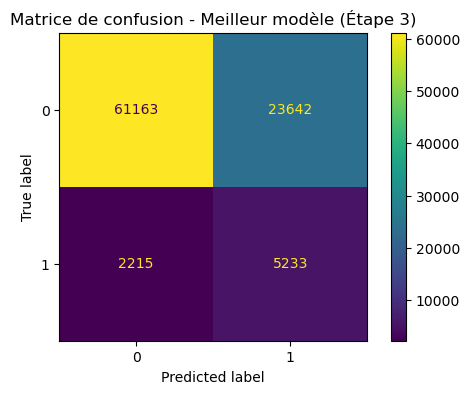

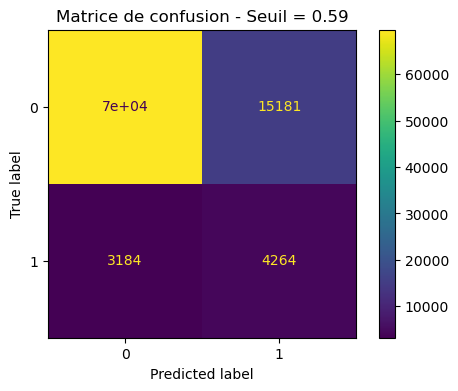

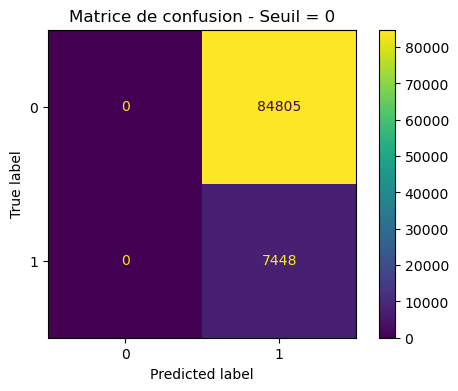

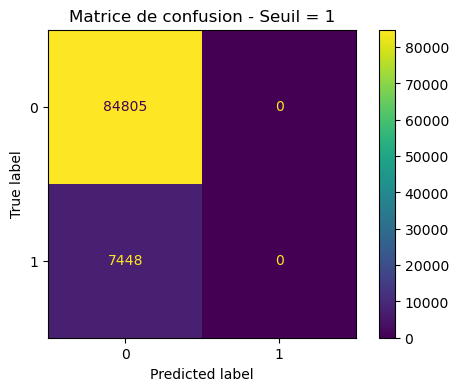

In [19]:
###############################################################################
# Matrice de confusion avec un seuil de probabilité par défaut (0.5)
###############################################################################
predictions_etape3 = grid_search_etape3.predict(X_test)

# Calcul de la matrice de confusion
matrice_confusion_etape3 = confusion_matrix(y_test, 
                                            predictions_etape3,
                                            labels=grid_search_etape3.best_estimator_.classes_)

# Création de l'objet ConfusionMatrixDisplay
affichage_matrice_confusion = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion_etape3)

# Affichage de la matrice de confusion
fig, axe_matrice_confusion = plt.subplots(1, 1, figsize=(6, 4))
affichage_matrice_confusion.plot(ax=axe_matrice_confusion)
axe_matrice_confusion.set_title("Matrice de confusion - Meilleur modèle (Étape 3)")
plt.show()


###############################################################################
# Matrice de confusion avec un seuil de probabilité = 0.59
###############################################################################
# Calcul des probabilités prédites sur les données de test
analyse_proba_etape3 = pd.DataFrame(grid_search_etape3.predict_proba(X_test))

# Application d'un seuil de 0.59
analyse_proba_etape3['prediction_finale'] = analyse_proba_etape3[1].apply(lambda x: 1 if x >= 0.59 else 0)

# Calcul de la matrice de confusion
matrice_confusion_seuil_etape3 = confusion_matrix(y_test, analyse_proba_etape3['prediction_finale'])

# Création de l'objet ConfusionMatrixDisplay
affichage_matrice_confusion_seuil = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion_seuil_etape3)

# Affichage de la matrice de confusion
fig, axe_matrice_confusion_seuil = plt.subplots(1, 1, figsize=(6, 4))
affichage_matrice_confusion_seuil.plot(ax=axe_matrice_confusion_seuil)
axe_matrice_confusion_seuil.set_title("Matrice de confusion - Seuil = 0.59")
plt.show()


###############################################################################
# Matrice de confusion avec un seuil de probabilité = 0
###############################################################################
# Calcul des probabilités prédites sur les données de test
probabilites_predictions_etape3 = pd.DataFrame(grid_search_etape3.predict_proba(X_test))

# Application d'un seuil de 0
probabilites_predictions_etape3['prediction_finale'] = probabilites_predictions_etape3[1].apply(lambda x: 1 if x >= 0 else 0)

# Calcul de la matrice de confusion
matrice_confusion_etape3_seuil_zero = confusion_matrix(y_test, probabilites_predictions_etape3['prediction_finale'])

# Création de l'objet ConfusionMatrixDisplay
affichage_matrice_confusion_seuil_zero = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion_etape3_seuil_zero)

# Affichage de la matrice de confusion
fig, axe_matrice_confusion_seuil_zero = plt.subplots(1, 1, figsize=(6, 4))
affichage_matrice_confusion_seuil_zero.plot(ax=axe_matrice_confusion_seuil_zero)
axe_matrice_confusion_seuil_zero.set_title("Matrice de confusion - Seuil = 0")
plt.show()


###############################################################################
# Matrice de confusion avec un seuil de probabilité = 1
###############################################################################
# Calcul des probabilités prédites sur les données de test
probabilites_predictions_etape3 = pd.DataFrame(grid_search_etape3.predict_proba(X_test))

# Application d'un seuil de 1
probabilites_predictions_etape3['prediction_finale'] = probabilites_predictions_etape3[1].apply(lambda x: 1 if x >= 1 else 0)

# Calcul de la matrice de confusion
matrice_confusion_etape3_seuil_un = confusion_matrix(y_test, probabilites_predictions_etape3['prediction_finale'])

# Création de l'objet ConfusionMatrixDisplay
affichage_matrice_confusion_seuil_un = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion_etape3_seuil_un)

# Affichage de la matrice de confusion
fig, axe_matrice_confusion_seuil_un = plt.subplots(1, 1, figsize=(6, 4))
affichage_matrice_confusion_seuil_un.plot(ax=axe_matrice_confusion_seuil_un)
axe_matrice_confusion_seuil_un.set_title("Matrice de confusion - Seuil = 1")
plt.show()

**Seuil de Probabilité fixé à 1**.
- Seules les observations ayant une probabilité exactement égale à 1 (ce qui est très rare) seront classées comme `1`.
- Pratiquement **toutes les observations** seront classées comme `0`, car les probabilités prédictives sont rarement égales à 1 dans un modèle.


- **Extrêmes (0 et 1)** : Les seuils à 0 et 1 représentent des cas extrêmes qui ne fournissent pas une réelle utilité pratique dans la plupart des applications :
  - **Seuil à 0** : Tout est classé comme `1`, ce qui est peu utile.
  - **Seuil à 1** : Presque tout est classé comme `0`, ce qui est également peu utile.

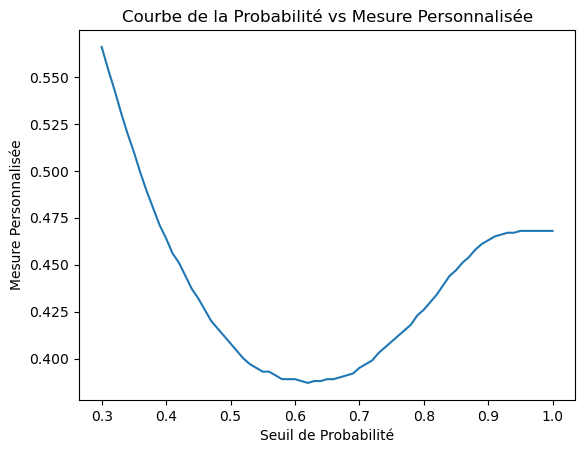

In [20]:
# Initialisation des listes pour stocker les probabilités et les mesures
liste_probabilites = []
liste_mesures = []

# Boucle pour calculer la mesure pour différentes valeurs de seuil de probabilité
for seuil in range(30, 101):
    # Calcul des probabilités prédites sur les données de test avec le meilleur modèle trouvé à l'étape 3
    predictions_probabilites_etape3 = pd.DataFrame(grid_search_etape3.predict_proba(X_test))
    
    # Application du seuil de probabilité pour la classification finale
    predictions_probabilites_etape3['prediction_finale'] = predictions_probabilites_etape3[1].apply(lambda x: 1 if x >= seuil / 100 else 0)
    
    # Calcul de la matrice de confusion basée sur le seuil de probabilité
    matrice_confusion_seuil = confusion_matrix(y_test, predictions_probabilites_etape3['prediction_finale'])
    
    # Calcul de la mesure personnalisée
    mesure_personnalisee = round(((matrice_confusion_seuil[1][0] * 10 + matrice_confusion_seuil[0][1]) / 
                                  (matrice_confusion_seuil[1][0] * 10 + matrice_confusion_seuil[0][1] + 
                                   matrice_confusion_seuil[0][0] + matrice_confusion_seuil[1][1])), 3)
    
    # Stockage des résultats dans les listes
    liste_mesures.append(mesure_personnalisee)
    liste_probabilites.append(seuil / 100)

# Visualisation de la courbe proba/score
sns.lineplot(x=liste_probabilites, y=liste_mesures)
plt.xlabel('Seuil de Probabilité')
plt.ylabel('Mesure Personnalisée')
plt.title('Courbe de la Probabilité vs Mesure Personnalisée')
plt.show()

- **Axe des X (Seuil de Probabilité)** : Représente les différents seuils de probabilité que nous avons appliqués pour classifier nos données. Par exemple, un seuil de 0.3 signifie que toutes les observations ayant une probabilité prédite supérieure ou égale à 0.3 sont classées comme positives (classe 1), et les autres comme négatives (classe 0).
  
- **Axe des Y (Mesure Personnalisée)** : Représente la valeur de la mesure personnalisée que nous avons calculée pour chaque seuil. Cette mesure prend en compte les faux négatifs avec un poids de 10, ce qui signifie qu'elle pénalise fortement les erreurs de classification des vrais positifs comme négatifs.



- **Forme de la courbe** :
  - **Descente initiale (de 0.3 à environ 0.6)** : Au fur et à mesure que le seuil de probabilité augmente, la mesure personnalisée diminue, indiquant une amélioration des performances du modèle. Cela suggère qu'à des seuils plus bas, il y a probablement plus de faux négatifs et faux positifs, ce qui conduit à une mesure personnalisée plus élevée (moins bonne).
  - **Point le plus bas (environ 0.6)** : Le point le plus bas de la courbe correspond au seuil où la mesure personnalisée est la plus faible, ce qui signifie que c'est le seuil optimal pour minimiser les erreurs pondérées par la pénalité que vous avez définie (faux négatifs pénalisés à 10 fois plus). C'est probablement le seuil à utiliser pour votre modèle pour obtenir les meilleures performances selon cette mesure.
  - **Montée après le point bas (au-delà de 0.6)** : Lorsque le seuil continue d'augmenter, la mesure personnalisée augmente à nouveau, ce qui signifie que des erreurs supplémentaires sont introduites (probablement plus de faux négatifs). Un seuil trop élevé peut entraîner un modèle qui manque de vrais positifs, augmentant ainsi la pénalité dans votre mesure personnalisée.



- Le **seuil optimal** Ce graphique semble se situer autour de 0.6, où la mesure personnalisée est minimale. Cela signifie que c'est le seuil où votre modèle atteint un équilibre optimal entre minimisation des faux positifs et des faux négatifs, en tenant compte de la pénalité.

## Exportation du modèle

**Pickle** est un module intégré dans Python utilisé pour la sérialisation et la désérialisation d'objets. La sérialisation, également appelée "pickling" en Python, consiste à convertir un objet Python en un format binaire qui peut être stocké dans un fichier ou transmis à travers un réseau. La désérialisation, ou "unpickling", est le processus inverse, où le format binaire est reconverti en l'objet Python d'origine.

In [21]:
import pickle

# Le chemin du fichier pour sauvegarder le modèle optimisé
chemin_fichier_modele = r'C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Données générée\Modele_optimise_etape3_pickle.sav'

# Sauvegarde du meilleur modèle optimisé à l'étape 3 en utilisant pickle
with open(chemin_fichier_modele, 'wb') as fichier:
    pickle.dump(grid_search_etape3.best_estimator_, fichier)

# Chemin du fichier pour réimporter le modèle
chemin_fichier_charge = r'C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Données générée\Modele_optimise_etape3_pickle.sav'

# Chargement du modèle précédemment sauvegardé
with open(chemin_fichier_charge, 'rb') as fichier_charge:
    modele_charge = pickle.load(fichier_charge)

# Utilisation du modèle réimporté pour faire des prédictions sur les données de test
predictions_probabilites = modele_charge.predict_proba(X_test)
predictions_probabilites = predictions_probabilites[:, 1]  # On conserve uniquement les probabilités pour la classe positive

# Affichage de la forme des résultats
print(predictions_probabilites.shape)

(92253,)


### Pipeline de prédiction

Nous souhaitons maintenant réunir toutes les étapes nécessaires à la prédiction dans des conditions réelles, pour cela nous devons regrouper les étapes de prétraitement et la régression dans un seul outil, c'est le rôle d'un pipeline.

In [22]:
from sklearn.pipeline import Pipeline

# Pipeline pour LGBMClassifier
pipeline = Pipeline([('regressor', LGBMClassifier(**grid_search_etape3.best_params_))])

# Lancement de l'apprentissage du pipeline sur les données d'entrainement
pipeline.fit(X_train, y_train)
grid_search_etape3.predict

<bound method BaseSearchCV.predict of GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LGBMClassifier(class_weight={0: 1, 1: 12},
                                      learning_rate=0.01, max_depth=7,
                                      min_child_weight=1, n_estimators=1000,
                                      objective='binary', random_state=42,
                                      verbose=-1),
             n_jobs=-1,
             param_grid={'reg_alpha': array([0. , 0.2, 0.4, 0.6, 0.8]),
                         'reg_lambda': range(0, 10, 2)},
             refit='lowest_penalty_score',
             scoring={'best_threshold': make_scorer(best_threshold_probability, response_method='predict_proba'),
                      'lowest_penalty_score': make_scorer(calculate_custom_metric, greater_is_better=False, response_method='predict_proba')})>

Le pipeline regroupe maintenant toutes les étapes nécessaires pour prédire sur des données, nous allons maintenant le déployer.

Sérialiser le pipeline à l'aide de joblib, sous le nom de fichier *pipeline_housing.joblib*.

**Joblib** est une bibliothèque Python conçue pour la sérialisation (sauvegarde et chargement) efficace des objets Python, en particulier ceux qui sont volumineux ou qui contiennent des données complexes comme des tableaux NumPy. Elle est également utilisée pour paralléliser les tâches dans des pipelines d'apprentissage automatique.

**Principales fonctionnalités de Joblib :** Sérialisation efficace, Compression, Parallélisme, Gestion de la mémoire


In [23]:
import joblib

joblib.dump(pipeline, 'pipeline_housing.joblib')

['pipeline_housing.joblib']

# 3 - Déploiement d'un modèle sklearn avec MLflow

> MLflow est une plateforme qui simplifie le développement de l'apprentissage automatique, en incluant le suivi des expériences, l'emballage du code dans des exécutions reproductibles, ainsi que le partage et **le déploiement des modèles**. MLflow propose un ensemble d'API légères qui peuvent être utilisées avec n'importe quelle application ou bibliothèque d'apprentissage automatique existante (TensorFlow, PyTorch, XGBoost, LightGBM, etc.), où que vous exécutiez actuellement du code ML (par exemple, dans des notebooks, des applications autonomes ou dans le cloud). Les composants actuels de MLflow sont :
>- **MLflow Tracking** : Une API pour enregistrer les paramètres, le code et les résultats des expériences d'apprentissage automatique et les comparer à l'aide d'une interface utilisateur interactive.
>- **MLflow Projects** : Un format d'emballage de code pour des exécutions reproductibles en utilisant Conda et Docker, vous permettant ainsi de partager votre code ML avec d'autres.
>- **MLflow Models** : Un format d'emballage de modèles et des outils qui vous permettent de déployer facilement le même modèle (à partir de n'importe quelle bibliothèque ML) pour le scoring par lots et en temps réel sur des plateformes telles que Docker, Apache Spark, Azure ML et AWS SageMaker.
>- **MLflow Model Registry** : Un stockage centralisé des modèles, un ensemble d'API et une interface utilisateur pour gérer de manière collaborative le cycle de vie complet des modèles MLflow.


MLflow est une librairie dédiée à la gestion du cycle de vie d'un projet de machine learning, à savoir :
- le suivi des résultats liés aux expériences (MLflow Tracking)
- garantir la reproducibilité des expériences et le partage de code (MLflow Projects)
- la gestion des modèles sous un format normalisé afin de simplifier les déploiements locaux ou cloud (MLflow Models)
- la centralisation et le versionnage les modèles (MLflow Model Registry)

**On s'intéresse dans le cadre de ce projet à MLflow Models uniquement**

### Format de stockage d'un modèle

Un modèle MLflow est un répertoire contenant une liste de fichiers, dont un nommé MLmodel qui liste les différentes flavors (terme MLflow) dans lesquelles le modèle est utilisable.

Les flavors sont une façon pratique de définir comment exécuter un modèle, cette convention facilite le déploiement car la flavor standardise la façon de prédire à partir d'un modèle. MLflow définit par exemple des flavors pour une fonction python, sklearn, tensorflow, xgboost.

### Signature d'un modèle

Afin de garantir que les données d'entrée d'un modèle sont conformes à ce qui est attendu, les modèles MLflow peuvent inclure des metadatas décrivant les entrées et sorties :
- Model Signature - description des entrées et sorties du modèle
- Model Input Example - exemple d'une entrée valide

La signature du modèle permet de renseigner le nom des colonnes et leurs types afin de vérifier si ils sont similaires lors de la prédiction.

[Documentation](https://mlflow.org/docs/latest/models.html#model-signature-and-input-example)

In [24]:
from mlflow.models.signature import infer_signature

# Extraction de la signature à partir des données d'entrée et de sortie
signature = infer_signature(X_train, y_train)

### Sauvegarde du modèle sklearn


Sauvegarder le pipeline à l'aide de la fonction [save_model](https://mlflow.org/docs/latest/python_api/mlflow.sklearn.html#mlflow.sklearn.save_model) en n'oubliant pas de préciser la signature.

In [26]:
import mlflow.sklearn

mlflow.sklearn.save_model(pipeline, 'mlflow_model', signature=signature)

## Mise en scène du modèle

In [27]:
from mlflow import MlflowClient
import mlflow.sklearn

# Initialisation du client MLflow pour interagir avec le registre des modèles
client_mlflow = MlflowClient()

# Nom du modèle que nous cherchons à manipuler
nom_modele = "Optimus-sklearn-LGBMClassifier"

# Vérification des modèles enregistrés dans MLflow
models = client_mlflow.search_registered_models()
model_names = [model.name for model in models]

if nom_modele not in model_names:
    # Si le modèle n'est pas trouvé, nous l'enregistrons dans MLflow
    print(f"Modèle '{nom_modele}' non trouvé, enregistrement en cours...")

    # Enregistrement du modèle dans MLflow
    mlflow.sklearn.log_model(
        sk_model=grid_search_etape3.best_estimator_,  # Le modèle entraîné et optimisé à l'étape 3
        artifact_path="model",                       # Le chemin relatif où les artefacts seront stockés
        registered_model_name=nom_modele             # Le nom sous lequel le modèle sera enregistré dans MLflow
    )

    print(f"Modèle '{nom_modele}' enregistré avec succès.")

# Récupérer la dernière version du modèle
latest_versions = client_mlflow.get_latest_versions(nom_modele, stages=["None"])
if latest_versions:
    version = latest_versions[0].version

    # Transition du modèle vers le stage "Production"
    client_mlflow.transition_model_version_stage(
        name=nom_modele, 
        version=version, 
        stage="Production"
    )
    print(f"Le modèle '{nom_modele}' version {version} a été déplacé vers le stage 'Production'.")
else:
    print(f"Pas de version trouvée pour le modèle '{nom_modele}'.") 

Pas de version trouvée pour le modèle 'Optimus-sklearn-LGBMClassifier'.


## Features importances

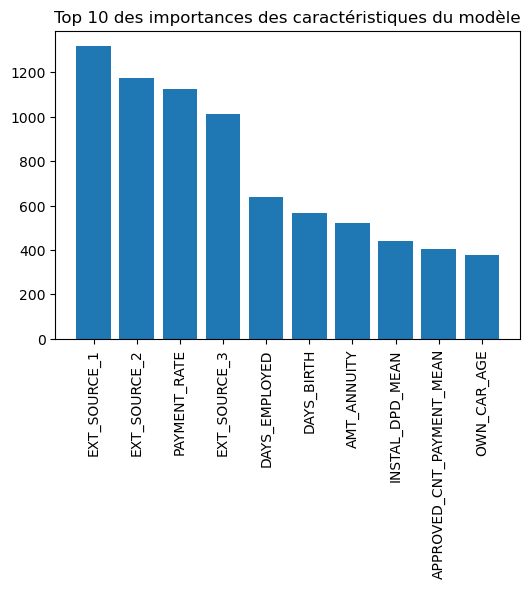

In [28]:
# Extraction des importances des caractéristiques du meilleur modèle
importances_caracteristiques = grid_search_etape3.best_estimator_.feature_importances_

# Extraction des noms des caractéristiques depuis les colonnes de X
noms_caracteristiques = X.columns

# Création d'un DataFrame avec les caractéristiques et leurs importances
df_importances = pd.DataFrame(list(zip(noms_caracteristiques, importances_caracteristiques)), columns=['Variables', 'Importance'])

# Tri du DataFrame par importance décroissante
df_importances = df_importances.sort_values('Importance', ascending=False)

# Visualisation des 10 principales caractéristiques
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.bar(df_importances['Variables'].head(10), df_importances['Importance'].head(10))
ax1 = plt.xticks(rotation=90)
ax1 = plt.title('Top 10 des importances des caractéristiques du modèle')

# Affichage du graphique
plt.show()

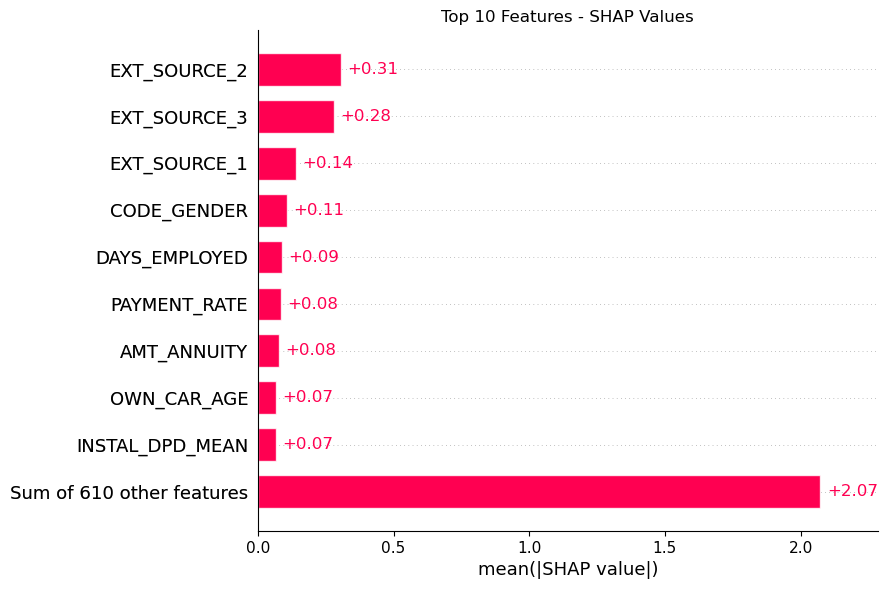

In [29]:
params = grid_search_etape3.best_params_.copy()
params['boosting_type'] = 'gbdt'        
params.pop('force_col_wise', None)     

# entraîner le modèle LightGBM
model = LGBMClassifier(**params)
model.fit(X_train, y_train)

import shap
explainer = shap.TreeExplainer(model)

# Générez les "SHAP values" comme un objet Explanation
shap_values_expl = explainer(X_train)  

# Affichez un barplot via shap.plots.bar
shap.plots.bar(shap_values_expl, max_display=10, show=False)
plt.title("Top 10 Features - SHAP Values")
plt.show()

- **EXT_SOURCE_2 (+0.31)** : Cette caractéristique a une influence importante sur la prédiction, avec une valeur SHAP moyenne de 0.31. Cela signifie que cette variable est une des principales raisons pour lesquelles le modèle prend ses décisions.
- **EXT_SOURCE_3 (+0.29)** : Cette caractéristique vient juste après `EXT_SOURCE_2` en termes d'importance, avec une contribution moyenne de 0.29 à la prédiction du modèle.
- Les autres caractéristiques listées ont des impacts variés, mais elles sont moins importantes par rapport aux premières.



- **Caractéristiques principales** : Ce graphique nous permet de voir quelles caractéristiques le modèle trouve les plus importantes pour effectuer ses prédictions.
- **Prise de décision** : Les responsables de la prise de décision peuvent utiliser cette information pour se concentrer sur les caractéristiques les plus critiques, par exemple lors de l'évaluation des risques ou de l'octroi de crédits.


Ce graphique est essentiel pour comprendre quelles caractéristiques influencent le plus les prédictions d'un modèle sur l'ensemble de nos données. `EXT_SOURCE_2`, `EXT_SOURCE_3`, et `EXT_SOURCE_1` sont les caractéristiques qui ont le plus d'impact, tandis que le reste des caractéristiques contribue également, mais de manière plus diffuse.

In [31]:
# Récupération des valeurs SHAP et des noms des caractéristiques
valeurs_shap_importantes = pd.DataFrame(zip(shap_values_expl[0].values, X_train.columns))

# Prendre la valeur absolue des importances SHAP et arrondir à 2 décimales
valeurs_shap_importantes[0] = abs(valeurs_shap_importantes[0]).round(2)

# Trier les caractéristiques par importance décroissante
valeurs_shap_importantes = valeurs_shap_importantes.sort_values(0, ascending=False)

# Sélection des 20 caractéristiques les plus importantes
meilleures_caracteristiques = list(valeurs_shap_importantes.iloc[:20][1])

# Conversion en DataFrame pour la sauvegarde
df_meilleures_caracteristiques = pd.DataFrame(meilleures_caracteristiques, columns=['Variables'])

# Sauvegarde des meilleures caractéristiques dans un fichier CSV
chemin_sauvegarde_variables = r'C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Données générée\Meilleures_Caracteristiques_Modele.csv'
df_meilleures_caracteristiques.to_csv(chemin_sauvegarde_variables, index=False)

In [36]:
import lime
from sklearn.impute import SimpleImputer
from lime.lime_tabular import LimeTabularExplainer

# Replace ±inf with NaN
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Impute NaN values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train),
                               columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test),
                              columns=X_test.columns)

# Initialize the LIME explainer
explainer_lime = LimeTabularExplainer(
    training_data=X_train_imputed.values,  
    feature_names=X_train_imputed.columns,
    class_names=['Classe 0', 'Classe 1'],
    mode='classification',
    discretize_continuous=False,
    verbose=True,
    random_state=42
)

# Explain an instance
observation_a_expliquer = X_test_imputed.iloc[0]
explication_lime = explainer_lime.explain_instance(
    data_row=observation_a_expliquer.values,
    predict_fn=grid_search_etape3.best_estimator_.predict_proba,
    num_features=10
)

# Show the explanation
explication_lime.show_in_notebook(show_table=True)

# 7. Save to HTML
chemin_sauvegarde_lime = r'C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Données générée\Explication_LIME.html'
explication_lime.save_to_file(chemin_sauvegarde_lime)


Intercept 0.3672640392210522
Prediction_local [0.26299174]
Right: 0.2383583049719686


## Nouveaux Clients et Analyse SHAP Locale

In [37]:
# Chargement des données des nouveaux clients
chemin_fichier_nouveaux_clients = r'C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Data_clean\NouveauxClientsComplets.csv'
nouveaux_clients = pd.read_csv(chemin_fichier_nouveaux_clients)

# Nettoyage des noms de colonnes pour ne conserver que les caractères alphanumériques et underscores
nouveaux_clients = nouveaux_clients.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# Définition des colonnes de référence à partir de 'Data.columns'
# (On retire 'TARGET' si elle ne doit pas être utilisée comme feature.)
colonnes_reference = [col for col in Data.columns if col != 'TARGET']

# On aligne (reindex) les colonnes de nouveaux_clients sur celles de colonnes_reference
# fill_value=0 permet de remplir par zéro les colonnes absentes, utile pour les variables dummies
nouveaux_clients = nouveaux_clients.reindex(columns=colonnes_reference, fill_value=0)

# (Optionnel) Si jamais vous tenez à supprimer 'TARGET' si elle est présente,
# laissez ce code, mais en principe si on a déjà exclu 'TARGET' ci-dessus, ce n'est plus nécessaire.
if 'TARGET' in nouveaux_clients.columns:
    del nouveaux_clients['TARGET']

# Création d'une liste des indices des nouveaux clients
indices_nouveaux_clients = list(nouveaux_clients.reset_index(drop=True).index)

# Sélection aléatoire d'un client parmi les nouveaux clients
indice_client_selectionne = random.choice(indices_nouveaux_clients)

# Affichage de l'indice du client sélectionné (de façon aléatoire)
indice_client_selectionne

15675

In [38]:
# Sélection du client spécifique qui vient de faire une demande de prêt
client_demande_pret = nouveaux_clients.iloc[indice_client_selectionne : indice_client_selectionne + 1]
client_demande_pret

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,...,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_POS others without interest_MEAN,PREV_PRODUCT_COMBINATION_nan_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,REFUSED_AMT_APPLICATION_MIN,REFUSED_AMT_APPLICATION_MAX,REFUSED_AMT_APPLICATION_MEAN,REFUSED_AMT_CREDIT_MIN,REFUSED_AMT_CREDIT_MAX,REFUSED_AMT_CREDIT_MEAN,REFUSED_APP_CREDIT_PERC_MIN,REFUSED_APP_CREDIT_PERC_MAX,REFUSED_APP_CREDIT_PERC_MEAN,REFUSED_AMT_GOODS_PRICE_MIN,REFUSED_AMT_GOODS_PRICE_MAX,REFUSED_AMT_GOODS_PRICE_MEAN,REFUSED_HOUR_APPR_PROCESS_START_MIN,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_SUM,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRAC

In [39]:
# Prédiction des probabilités de la classe pour le client demandeur en utilisant le modèle optimisé
probabilites_client_demande_pret = grid_search_etape3.predict_proba(client_demande_pret)

# Conversion des probabilités en DataFrame pour une visualisation plus claire
df_probabilites_client_demande_pret = pd.DataFrame(probabilites_client_demande_pret)

# Affichage des probabilités prédites
df_probabilites_client_demande_pret

,0,1
0,0.840281,0.159719


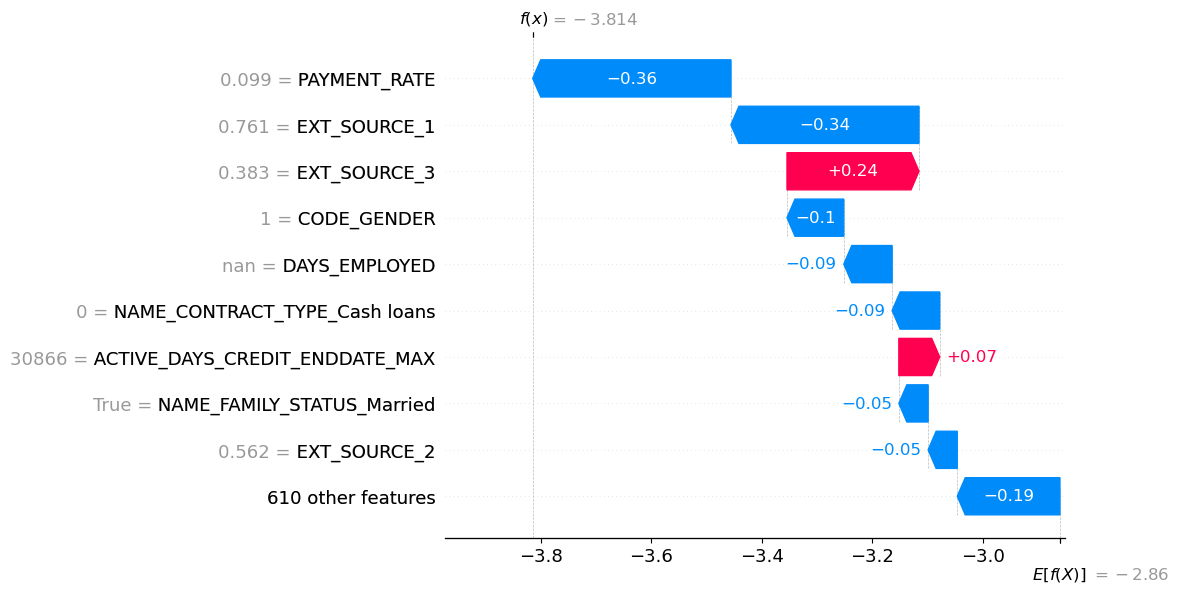

In [40]:
# Forcer un boosting "gbdt" et retirer le paramètre "force_col_wise" si présent
params = grid_search_etape3.best_params_.copy()
params['boosting_type'] = 'gbdt'
params.pop('force_col_wise', None)

# entraîner un nouveau modèle LightGBM avec ces paramètres
from lightgbm import LGBMClassifier
modele_final = LGBMClassifier(**params)
modele_final.fit(X_train, y_train)

# Création de l'explainer SHAP 
import shap
explainer = shap.TreeExplainer(modele_final, feature_perturbation="tree_path_dependent")

# Sélection du client dans les nouveaux clients 
client_demande_pret = nouveaux_clients.iloc[[indice_client_selectionne]]

# Calcul des valeurs SHAP pour ce client
explanation_client = explainer(client_demande_pret)

# Visualisation 
shap.plots.waterfall(explanation_client[0], max_display=10)
plt.show()


# A modifier


- **EXT_SOURCE_1 et AMT_GOODS_PRICE ont des effets négatifs importants**, ce qui signifie que ces caractéristiques réduisent la probabilité que ce client soit classé dans une certaine catégorie (par exemple, être approuvé pour un prêt).

- **OWN_CAR_AGE, REGION_RATING_CLIENT_W_CITY et d'autres caractéristiques rouges** ont des effets positifs, ce qui signifie qu'elles augmentent la probabilité de cette classification.

- **610 autres caractéristiques** : Cette mention indique que le modèle utilise de nombreuses autres caractéristiques qui, combinées, ont une contribution totale non négligeable. Cependant, elles ne sont pas listées individuellement pour simplifier la visualisation.


**Utilité de cette Analyse Locale :**

- **Individu spécifique** : Ce diagramme est utile pour comprendre pourquoi le modèle a pris une décision spécifique pour cet individu particulier.
- **Explication de la prédiction** : En observant ce graphique, un analyste ou un décideur peut voir quelles caractéristiques ont le plus influencé la prédiction et dans quelle direction.

**Le diagramme SHAP** montre exactement comment chaque caractéristique a influencé la prédiction du modèle pour ce client spécifique.

In [42]:
# Récupérer correctement les valeurs SHAP pour le client
shap_values_du_client = explanation_client.values[0]

# Construire une DataFrame associant "SHAP_value" et "Feature"
variables_importantes_client_demande_pret = pd.DataFrame({
    "SHAP_value": shap_values_du_client,
    "Feature": X_train.columns})

# Mettre en valeur absolue et arrondir
variables_importantes_client_demande_pret["SHAP_value"] = (
    variables_importantes_client_demande_pret["SHAP_value"].abs().round(2))

# Trier par ordre décroissant d'importance
variables_importantes_client_demande_pret = variables_importantes_client_demande_pret.sort_values(
    "SHAP_value", ascending=False)

# Sélection des 100 caractéristiques les plus importantes pour ce client
top_100_caracteristiques_client_demande_pret = list(
    variables_importantes_client_demande_pret["Feature"].head(100))

top_100_caracteristiques_client_demande_pret

['PAYMENT_RATE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'CODE_GENDER',
 'DAYS_EMPLOYED',
 'NAME_CONTRACT_TYPE_Cash_loans',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'NAME_FAMILY_STATUS_Married',
 'EXT_SOURCE_2',
 'FLAG_DOCUMENT_3',
 'AMT_GOODS_PRICE',
 'INSTAL_AMT_PAYMENT_MEAN',
 'ACTIVE_DAYS_CREDIT_MAX',
 'INSTAL_AMT_PAYMENT_MIN',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'OWN_CAR_AGE',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'BURO_MONTHS_BALANCE_SIZE_SUM',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_BIRTH',
 'PREV_CNT_PAYMENT_MEAN',
 'CLOSED_AMT_CREDIT_SUM_SUM',
 'BURO_CREDIT_ACTIVE_Closed_MEAN',
 'CLOSED_DAYS_CREDIT_MAX',
 'PREV_NAME_TYPE_SUITE_nan_MEAN',
 'ANNUITY_INCOME_PERC',
 'NAME_EDUCATION_TYPE_Secondary___secondary_special',
 'BURO_DAYS_CREDIT_UPDATE_MEAN',
 'NAME_EDUCATION_TYPE_Higher_education',
 'INSTAL_DAYS_ENTR

## Test de prédiction avec MLFlow

In [43]:
# Chargement des données des nouveaux clients à partir du fichier CSV
chemin_fichier_nouveaux_clients = r'C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Data_clean\NouveauxClientsComplets.csv'
donnees_nouveaux_clients = pd.read_csv(chemin_fichier_nouveaux_clients)

# Nettoyage des noms de colonnes pour ne conserver que les caractères alphanumériques et underscores
donnees_nouveaux_clients = donnees_nouveaux_clients.rename(
    columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x)
)

# Filtrer les colonnes pour ne garder que celles présentes dans le CSV
colonnes_existantes = [col for col in colonnes_avec_moins_de_70_nan 
                       if col in donnees_nouveaux_clients.columns]

# Sélection des variables pertinentes, en conservant uniquement la première observation (1ère ligne)
donnees_client_selectionne = (donnees_nouveaux_clients.iloc[0:1].reindex(columns=colonnes_avec_moins_de_70_nan, fill_value=0))
#donnees_client_selectionne = donnees_nouveaux_clients
# Suppression de la colonne 'TARGET' si elle est présente
if 'TARGET' in donnees_client_selectionne.columns:
    del donnees_client_selectionne['TARGET']

# Affichage des données pour le client sélectionné
donnees_client_selectionne

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,...,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_POS others without interest_MEAN,PREV_PRODUCT_COMBINATION_nan_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,REFUSED_AMT_APPLICATION_MIN,REFUSED_AMT_APPLICATION_MAX,REFUSED_AMT_APPLICATION_MEAN,REFUSED_AMT_CREDIT_MIN,REFUSED_AMT_CREDIT_MAX,REFUSED_AMT_CREDIT_MEAN,REFUSED_APP_CREDIT_PERC_MIN,REFUSED_APP_CREDIT_PERC_MAX,REFUSED_APP_CREDIT_PERC_MEAN,REFUSED_AMT_GOODS_PRICE_MIN,REFUSED_AMT_GOODS_PRICE_MAX,REFUSED_AMT_GOODS_PRICE_MEAN,REFUSED_HOUR_APPR_PROCESS_START_MIN,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_SUM,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRAC

In [44]:
# Charger le modèle LGBMClassifier depuis MLflow
model = mlflow.sklearn.load_model("models:/Optimus-sklearn-LGBMClassifier/Production")

# Préparer les données du client pour la prédiction
predictions = model.predict_proba(donnees_client_selectionne.values.tolist())
print("Probabilités de prédiction :", predictions)

Probabilités de prédiction : [[0.6388642 0.3611358]]


In [45]:
# Définir le nom du modèle et l'étape (Production)
model_name = "Optimus-sklearn-LGBMClassifier"
stage = "Production"

# Charger le modèle depuis MLflow
model = mlflow.sklearn.load_model(model_uri=f"models:/{model_name}/{stage}")

# Prédire les probabilités avec les données du client
model.predict_proba(donnees_client_selectionne.values.tolist())

array([[0.6388642, 0.3611358]])

In [46]:
import mlflow

current_uri = mlflow.get_tracking_uri()
print("MLflow tracking URI:", current_uri)


MLflow tracking URI: file:///'C:\Users\Bruno\Desktop\OCR\Projet\P7 - Implémentez un modèle de scoring\Notebook\mlflow_runs'
